#### DCGAN implementation in Pytorch

##### In this implementation, 
- Architecture of Generator and Discriminator are slightly different then given in the original paper. Example- we have normalised image from 0 to 1 for discriminator input, and used sigmoid activation function at output the generator instead of tanh.
- The generator of DCGAN generates color images with the resolution of 64x64.

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm 
import numpy as np
import os
from dcgan_model import DCGAN_Discriminator, DCGAN_Generator
from dataloader import CustomImageDataset
from matplotlib import pyplot as plt
import cv2
import glob
import random

In [2]:
root_path = "./"

#### Generate Train Dataset

####  CelebFaces Attributes (CelebA) Dataset
Download Dataset from [kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)
Create Train data split. Put all the raw images inside `raw_data` directory shown as in the following structure

```
|-dataset/
|   |
|   |-train/
|   |
|   
|   
|-raw_data/
|-generated/   # this folder will contain images generated by GAN
```

In [8]:
filename_list = glob.glob("raw_data/*.jpg")

In [7]:
# copy data from raw_data/ to dataset/train/
# note: we are using the data as it is, without much preprocessing

for filename in filename_list:
    command = "cp "+filename+" dataset/train/"+filename.split("/")[-1]
    os.system(command)  

##### Architecture related parameters for Generator and Discriminator are defined

In [65]:
noise_dim = 64
generator_channel = 8
discriminator_filter = 4

#### Initialise generator and discriminator

In [66]:
dcgan_generator = DCGAN_Generator(mode="run", enc_output_channels=generator_channel, noise_dim= noise_dim)
dcgan_discriminator = DCGAN_Discriminator(enc_output_channels=discriminator_filter, mode="run")

#### Check the Generator and Discriminator architectures by passing dummy inputs

In [67]:
batch_size = 5
input_tensor = torch.randn([batch_size,noise_dim])
output = dcgan_generator(input_tensor, batch_size, noise_dim= noise_dim)
print(output.shape)

torch.Size([5, 3, 64, 64])


In [68]:
input_tensor = torch.randn([batch_size, 3, 64, 64])
output = dcgan_discriminator(input_tensor, )
print(output.shape)

torch.Size([5, 1])


##### Model Parameters

In [74]:
LR_GEN = 1e-3
LR_DISC = 1e-3
DIM = 64
EPOCH = 5
MODE = "train"
loss_fn = nn.BCELoss()
gen_optimizer = optim.Adam(dcgan_generator.parameters(), betas=(0.3,0.999), lr=LR_GEN)
gen_scheduler = StepLR(gen_optimizer, step_size=4, gamma=0.1)
disc_optimizer = optim.Adam(dcgan_discriminator.parameters(), betas=(0.3,0.999), lr=LR_DISC)
disc_scheduler = StepLR(disc_optimizer, step_size=4, gamma=0.1)

#### Data Transformation

In [75]:
transform = A.Compose(
                [   A.Resize(height=DIM, width=DIM),
                    ToTensorV2(),
                ],
                )

#### Data loader

In [76]:
training_data = CustomImageDataset(transform, mode="train")
train_dataloader = DataLoader(training_data, batch_size=40, shuffle=True, pin_memory=True)

#### Function to calculate accuracy of classification of Discriminator

In [77]:
def label_wise_accuracy(output, target):
    pred = (output > 0.5).float()
    correct = (pred == target).float()
    label_accuracy = torch.mean(correct)
    return label_accuracy

#### DCGAN Training

In [78]:
gen_epoch_tr_loss = []
gen_epoch_tr_acc = []

disc_epoch_tr_loss = []
disc_epoch_tr_acc = []


ep_to_load_model = 1
valid_loss_min = np.Inf
clip_value = 3

In [79]:
batch_size = 0
gen_batch = 10
epoch_train_acc_discriminator, epoch_train_acc_generator = 0,0
disc_epoch_train_loss, gen_epoch_train_loss = 0,0
generated_img_row = None
for ep in range(EPOCH):
    train_acc_discriminator = 0
    train_acc_generator = 0
    train_batch_run_generator, train_batch_run_discriminator = 0, 0
    disc_train_losses, gen_train_losses = [], []
    dcgan_generator.train()
    dcgan_discriminator.train()
    with tqdm(train_dataloader, unit=" Train batch") as tepoch:
        tepoch.set_description(f"Train Epoch {ep+1}")
        for input_images, gt_paths in tepoch:
            
            batch_size = len(input_images)
            noise_input = torch.randn([batch_size,noise_dim]).float()
            noise_labels = torch.tensor([[0]]*batch_size)
            real_labels = torch.tensor([[1]]*batch_size)
            
            # TRAIN DISCRIMINATOR
            train_batch_run_discriminator += 1
            disc_optimizer.zero_grad()
            
            
            ## original image is passed to discriminator
            discriminator_output = dcgan_discriminator(input_images.float())
            real_loss_value = loss_fn(discriminator_output, real_labels.float())            
            real_loss_value.backward()
                       
            ## generator created image is passed to discriminator
            dcgan_generator.eval()
            generator_output = dcgan_generator(noise_input, batch_size, noise_dim).detach()
            noise_discriminator_output = dcgan_discriminator(generator_output)
            noise_loss_value = loss_fn(noise_discriminator_output, noise_labels.float())
            train_acc_discriminator += label_wise_accuracy(noise_discriminator_output, noise_labels)
            noise_loss_value.backward()
            
            ## total loss for discriminator
            loss_value = real_loss_value + noise_loss_value
            disc_train_losses.append(loss_value.item())
            
            nn.utils.clip_grad_norm_(dcgan_discriminator.parameters(), clip_value)
            disc_optimizer.step()
            
            #########################################################################
            
            # TRAIN GENERATOR
            dcgan_generator.train()
            gen_optimizer.zero_grad()
            noise_input = torch.randn([batch_size,noise_dim]).float()
            real_labels = torch.tensor([[1]]*batch_size)
            train_batch_run_generator += 1
            
            ## noise is passed to Generator. Generator's output Image is passed to Discriminator
            generator_output = dcgan_generator(noise_input, batch_size, noise_dim)
            discriminator_output = dcgan_discriminator(generator_output)
            gen_loss_value = loss_fn(discriminator_output, real_labels.float())
            train_acc_generator += label_wise_accuracy(discriminator_output, real_labels)
            gen_train_losses.append(gen_loss_value.item())
            gen_loss_value.backward()
            nn.utils.clip_grad_norm_(dcgan_generator.parameters(), clip_value)
            gen_optimizer.step()

     
        gen_epoch_train_loss = np.mean(gen_train_losses)
        epoch_train_acc_generator = train_acc_generator/train_batch_run_generator
        gen_epoch_tr_loss.append(gen_epoch_train_loss)
        gen_epoch_tr_acc.append(epoch_train_acc_generator*100)
        gen_scheduler.step()

        disc_epoch_train_loss = np.mean(disc_train_losses)
        epoch_train_acc_discriminator = train_acc_discriminator/train_batch_run_discriminator 
        disc_epoch_tr_loss.append(disc_epoch_train_loss)
        disc_epoch_tr_acc.append(epoch_train_acc_discriminator*100)
        disc_scheduler.step()
        

    
    print(f'discriminator train_loss : {disc_epoch_train_loss} discriminator train_accuraccy: {epoch_train_acc_discriminator*100}')
    print(f'generator train_loss : {gen_epoch_train_loss} generator train_accuracy : {epoch_train_acc_generator*100} ')
    os.system("rm ./models/*")
    print("removing stored weights of previous epoch")
    torch.save(dcgan_generator.state_dict(), root_path+"models/dcgan_generator_"+str(ep+1)+".pt")
    torch.save(dcgan_discriminator.state_dict(), root_path+"models/dcgan_discriminator_"+str(ep+1)+".pt")
    print("storing weights of current epoch")
    ep_to_load_model = ep+1
    print(25*'==')

    ## After every epoch, generate 100 images from generator.
    dcgan_generator.eval()
    generated_img_row = None
    for gen_idx in range(gen_batch):
        random_input = torch.randn([gen_batch,noise_dim]).float()
        with torch.no_grad():
            generated_output = dcgan_generator(random_input, batch = gen_batch, noise_dim= noise_dim).detach()
        # store generated images inside generated/ directory
        count = 0
        col_img = None
        for output in generated_output:
            prediction = output.numpy()*255
            prediction = prediction.astype(np.uint8)
            img = cv2.merge([prediction[0],prediction[1],prediction[2]])
            if count == 0:
                col_img = img
            else:
                col_img = cv2.hconcat([col_img, img])
            count = count + 1
        if gen_idx == 0:
            generated_img_row = col_img
        else:
            generated_img_row = cv2.vconcat([generated_img_row, col_img])
    
    cv2.imwrite("generated/generated_"+str(ep)+".jpg",generated_img_row)

Train Epoch 1: 100%|██████████████| 5065/5065 [18:15<00:00,  4.62 Train batch/s]


discriminator train_loss : 1.1333789863479338 discriminator train_accuraccy: 73.47882080078125
generator train_loss : 1.2649556994379332 generator train_accuracy : 16.148134231567383 
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 2: 100%|██████████████| 5065/5065 [13:26<00:00,  6.28 Train batch/s]


discriminator train_loss : 0.9362153762008218 discriminator train_accuraccy: 81.7700424194336
generator train_loss : 1.5349685096611276 generator train_accuracy : 15.254274368286133 
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 3: 100%|██████████████| 5065/5065 [13:13<00:00,  6.38 Train batch/s]


discriminator train_loss : 0.8591665744075417 discriminator train_accuraccy: 84.52677917480469
generator train_loss : 1.6564725608133728 generator train_accuracy : 13.222180366516113 
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 4: 100%|██████████████| 5065/5065 [13:02<00:00,  6.47 Train batch/s]


discriminator train_loss : 0.786343971450849 discriminator train_accuraccy: 86.34809112548828
generator train_loss : 1.8382966394132594 generator train_accuracy : 11.64018726348877 
removing stored weights of previous epoch
storing weights of current epoch


Train Epoch 5: 100%|██████████████| 5065/5065 [13:10<00:00,  6.41 Train batch/s]


discriminator train_loss : 0.6186869286890679 discriminator train_accuraccy: 90.84676361083984
generator train_loss : 2.1555738985479644 generator train_accuracy : 8.99854850769043 
removing stored weights of previous epoch
storing weights of current epoch


### Visualise GAN generated 100 color images of human with resolution of 64x64

In [81]:
##### Load weight of Generator

In [83]:
dcgan_generator.load_state_dict(torch.load(root_path+"models/dcgan_generator_"+str(ep_to_load_model)+".pt"))

<All keys matched successfully>

In [209]:
generated_img_row = None
dcgan_generator.eval()
for gen_idx in range(gen_batch):
    random_input = torch.randn([gen_batch,noise_dim]).float()
    with torch.no_grad():
        generated_output = dcgan_generator(random_input, batch = gen_batch, noise_dim= noise_dim).detach()
    # store generated images inside generated/ directory
    count = 0
    col_img = None
    for output in generated_output:
        prediction = output.numpy()*255
        prediction = prediction.astype(np.uint8)
        img = cv2.merge([prediction[0],prediction[1],prediction[2]])
        if count == 0:
            col_img = img
        else:
            col_img = cv2.hconcat([col_img, img])
        count = count + 1
    if gen_idx == 0:
        generated_img_row = col_img
    else:
        generated_img_row = cv2.vconcat([generated_img_row, col_img])
cv2.imwrite("generated/sample_generated.jpg",generated_img_row)

True

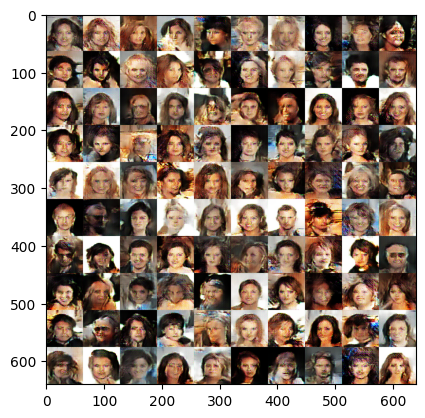

In [210]:
generated_img_row_b, generated_img_row_g, generated_img_row_r = cv2.split(generated_img_row)
generated_img_row = cv2.merge([generated_img_row_r, generated_img_row_g, generated_img_row_b])
plt.imshow(generated_img_row)

#### Graphs to visualise loss and Accuracy

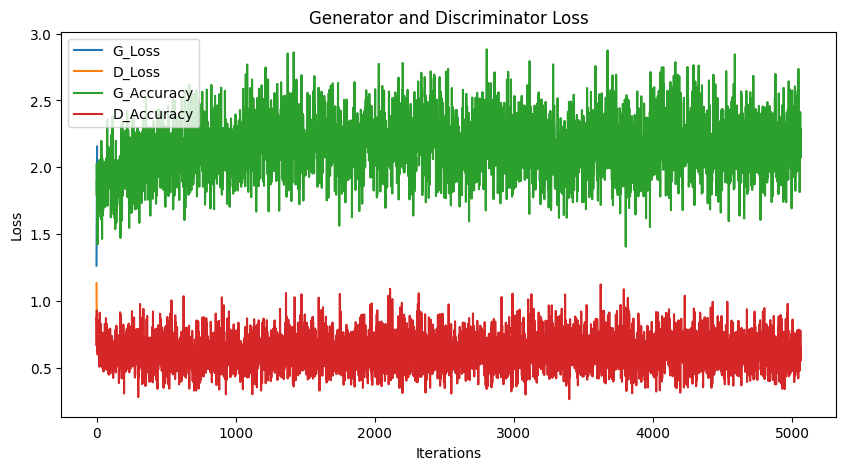

In [184]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(gen_epoch_tr_loss,label="G_Loss")
plt.plot(disc_epoch_tr_loss,label="D_Loss")
plt.plot(gen_train_losses,label="G_Accuracy")
plt.plot(disc_train_losses,label="D_Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Note: To get even more clearer generated images, one can try:
- Try changing the size of noise dimension (i.e. noise_dim)
- Put more training epochs.
- Better data preprocessing. Example- here we have used the images without any cropping.
- Change model architecture of generator and discriminator such as batch normalization, or adding more trainable parameter etc.
- Change the loss functions. As this implementation uses generic loss function given for GAN; a lot of research suggests different loss function for genereating clearer images.